# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #2

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


In [8]:
import tempfile

from code_analysis import AST, CFG, ASTReader
from graphviz.sources import Source
from IPython.display import Image

reader = ASTReader()


def show_cfg(cfg: CFG) -> Image:
    dot = cfg.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        return Image(f.name + ".png")

In [9]:
class ASTtoCFGVisitor:
    def __init__(self, ast: AST):
        self.ast = ast
        self.cfg = CFG()
        self.curr_nid = 0

        self.handlers = {
            "FunctionCall": self.visit_funccall,
            "BinOP": self.visit_binop,
            "Variable": self.visit_variable,
            "IfThenElseStatement": self.visit_ifelse,
            "Condition": self.visit_condition,
            "RelOP": self.visit_relop,
            "StatementBody": self.visit_statementbody,
            "Block": self.iter_children,
            "While": self.visit_while,
            "IfThenStatement": self.visit_if,
            "Argument": self.visit_argument,
            "Continue": self.visit_continue,
            "Break": self.visit_break,
        }

    def get_new_nid(self) -> int:
        self.curr_nid += 1
        return self.curr_nid

    @classmethod
    def visit(cls, ast: AST) -> CFG:
        visitor = cls(ast)
        print(f"Visit AST from file {visitor.ast.get_filename()}")
        visitor.visit_root(ast.get_root())
        return visitor.cfg

    def visit_root(self, ast_nid: int) -> int | None:
        entry_nid = self.get_new_nid()
        self.cfg.set_root(entry_nid)
        self.cfg.set_type(entry_nid, "Entry")
        self.cfg.set_image(entry_nid, "main")
        self.cfg.set_node_ptr(ast_nid, entry_nid)

        exit_nid = self.get_new_nid()
        self.cfg.set_type(exit_nid, "Exit")

        last_child_nid = self.iter_children(ast_nid, entry_nid, entry_nid, exit_nid)
        assert last_child_nid is not None
        self.cfg.add_edge(last_child_nid, exit_nid)

        return exit_nid

    def iter_children(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        children = self.ast.get_children(ast_nid)
        new_parent_nid = parent_nid
        for child_node in children:
            new_parent_nid = self.visit_node(
                child_node, new_parent_nid, block_start_nid, block_end_nid
            )
        return new_parent_nid

    def visit_node(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        node_type = self.ast.get_type(ast_nid)
        # print(f"Visiting node {ast_nid} ({node_type}) with parent {parent_nid}")
        # display(show_cfg(self.cfg))
        handler = self.handlers.get(node_type, self.visit_generic)
        return handler(ast_nid, parent_nid, block_start_nid, block_end_nid)

    def visit_generic(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        print(f"Generic visit for {self.ast.get_type(ast_nid)}")
        nid = self.get_new_nid()
        self.cfg.set_type(nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, nid)

        last_child_nid = self.iter_children(
            ast_nid, nid, block_start_nid, block_end_nid
        )

        return last_child_nid

    def visit_funccall(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        funccall_nid = self.get_new_nid()
        self.cfg.set_type(funccall_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(funccall_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, funccall_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, funccall_nid)

        callbegin_nid = self.get_new_nid()
        self.cfg.set_type(callbegin_nid, "CallBegin")
        self.cfg.set_image(callbegin_nid, self.ast.get_image(ast_nid))

        callend_nid = self.get_new_nid()
        self.cfg.set_type(callend_nid, "CallEnd")
        self.cfg.set_image(callend_nid, self.ast.get_image(ast_nid))

        self.cfg.set_call(callbegin_nid, callend_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        id_node, arglist_node = children[0], children[1]

        id_cfg_nid = self.visit_node(
            id_node, funccall_nid, block_start_nid, block_end_nid
        )
        assert id_cfg_nid is not None
        self.cfg.set_call_expr(callbegin_nid, id_cfg_nid)

        arglist_nid = self.get_new_nid()
        self.cfg.set_type(arglist_nid, self.ast.get_type(arglist_node))
        self.cfg.set_node_ptr(arglist_node, arglist_nid)

        self.cfg.add_edge(id_cfg_nid, arglist_nid)

        args_nodes = self.ast.get_children(arglist_node)
        new_parent_nid = arglist_nid
        for arg_node in args_nodes:
            new_parent_nid = self.visit_node(
                arg_node, new_parent_nid, block_start_nid, block_end_nid
            )
            assert new_parent_nid is not None
            self.cfg.add_call_arg(callbegin_nid, new_parent_nid)

        self.cfg.add_edge(new_parent_nid, callbegin_nid)

        retval_nid = self.get_new_nid()
        self.cfg.set_type(retval_nid, "RetValue")

        self.cfg.add_edge(callend_nid, retval_nid)

        return retval_nid

    def visit_binop(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        binop_nid = self.get_new_nid()
        self.cfg.set_type(binop_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(binop_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, binop_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        var_node, val_node = children[0], children[1]

        val_cfg_id = self.visit_node(
            val_node, parent_nid, block_start_nid, block_end_nid
        )
        var_cfg_id = self.visit_node(
            var_node, val_cfg_id, block_start_nid, block_end_nid
        )
        assert var_cfg_id is not None
        assert val_cfg_id is not None

        self.cfg.add_edge(var_cfg_id, binop_nid)
        self.cfg.set_op_hands(binop_nid, var_cfg_id, val_cfg_id)

        return binop_nid

    def visit_variable(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        nid = self.visit_generic(ast_nid, parent_nid, block_start_nid, block_end_nid)
        assert nid is not None
        self.cfg.set_var_id(nid, self.ast.get_var_id(ast_nid))
        self.cfg.set_var_scope(nid, self.ast.get_var_scope(ast_nid))
        return nid

    def visit_ifelse(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        if_nid = self.get_new_nid()
        self.cfg.set_type(if_nid, "If")
        self.cfg.set_node_ptr(ast_nid, if_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, if_nid)

        end_nid = self.get_new_nid()
        self.cfg.set_type(end_nid, "IfEnd")

        children = self.ast.get_children(ast_nid)
        assert len(children) == 3
        cond_node, then_node, else_node = children[0], children[1], children[2]

        cond_cfg_nid = self.visit_node(
            cond_node, if_nid, block_start_nid, block_end_nid
        )
        then_cfg_nid = self.visit_node(
            then_node, cond_cfg_nid, block_start_nid, block_end_nid
        )
        else_cfg_nid = self.visit_node(
            else_node, cond_cfg_nid, block_start_nid, block_end_nid
        )
        assert then_cfg_nid is not None
        assert else_cfg_nid is not None

        self.cfg.add_edge(then_cfg_nid, end_nid)
        self.cfg.add_edge(else_cfg_nid, end_nid)

        return end_nid

    def visit_condition(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        children = self.ast.get_children(ast_nid)
        assert len(children) == 1
        rel_node = children[0]

        rel_cfg_nid = self.visit_node(
            rel_node, parent_nid, block_start_nid, block_end_nid
        )
        assert rel_cfg_nid is not None

        cond_nid = self.get_new_nid()
        self.cfg.set_type(cond_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, cond_nid)

        self.cfg.add_edge(rel_cfg_nid, cond_nid)

        return cond_nid

    def visit_relop(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        relop_nid = self.get_new_nid()
        self.cfg.set_type(relop_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(relop_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, relop_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        left_node, right_node = children[0], children[1]

        left_cfg_id = self.visit_node(
            left_node, parent_nid, block_start_nid, block_end_nid
        )
        right_cfg_id = self.visit_node(
            right_node, left_cfg_id, block_start_nid, block_end_nid
        )
        assert left_cfg_id is not None
        assert right_cfg_id is not None

        self.cfg.add_call_arg(relop_nid, left_cfg_id)
        self.cfg.add_call_arg(relop_nid, right_cfg_id)

        self.cfg.add_edge(right_cfg_id, relop_nid)

        return relop_nid

    def visit_statementbody(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        children = self.ast.get_children(ast_nid)
        assert len(children) == 1
        block_node = children[0]
        return self.visit_node(block_node, parent_nid, block_start_nid, block_end_nid)

    def visit_while(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        while_nid = self.get_new_nid()
        self.cfg.set_type(while_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, while_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, while_nid)

        while_end_nid = self.get_new_nid()
        self.cfg.set_type(while_end_nid, "WhileEnd")

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        cond_node, block_node = children[0], children[1]

        cond_cfg_nid = self.visit_node(
            cond_node, while_nid, block_start_nid, block_end_nid
        )
        block_cfg_nid = self.visit_node(
            block_node, cond_cfg_nid, while_nid, while_end_nid
        )
        assert cond_cfg_nid is not None
        assert block_cfg_nid is not None

        self.cfg.add_edge(block_cfg_nid, while_nid)
        self.cfg.add_edge(cond_cfg_nid, while_end_nid)

        return while_end_nid

    def visit_if(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        if_nid = self.get_new_nid()
        self.cfg.set_type(if_nid, "If")
        self.cfg.set_node_ptr(ast_nid, if_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, if_nid)

        end_nid = self.get_new_nid()
        self.cfg.set_type(end_nid, "IfEnd")

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        cond_node, then_node = children[0], children[1]

        cond_cfg_nid = self.visit_node(
            cond_node, if_nid, block_start_nid, block_end_nid
        )
        assert cond_cfg_nid is not None
        self.cfg.add_edge(cond_cfg_nid, end_nid)

        then_cfg_nid = self.visit_node(
            then_node, cond_cfg_nid, block_start_nid, block_end_nid
        )
        if then_cfg_nid is not None:
            self.cfg.add_edge(then_cfg_nid, end_nid)

        return end_nid

    def visit_argument(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        arg_nid = self.get_new_nid()
        self.cfg.set_type(arg_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, arg_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 1
        arg_val_node = children[0]

        arg_val_nid = self.visit_node(
            arg_val_node, parent_nid, block_start_nid, block_end_nid
        )
        assert arg_val_nid is not None
        self.cfg.add_edge(arg_val_nid, arg_nid)

        return arg_nid

    def visit_continue(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        continue_nid = self.get_new_nid()
        self.cfg.set_type(continue_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, continue_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, continue_nid)

        self.cfg.add_edge(continue_nid, block_start_nid)
        return None

    def visit_break(
        self,
        ast_nid: int,
        parent_nid: int | None,
        block_start_nid: int,
        block_end_nid: int,
    ) -> int | None:
        break_nid = self.get_new_nid()
        self.cfg.set_type(break_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, break_nid)

        if parent_nid is not None:
            self.cfg.add_edge(parent_nid, break_nid)

        self.cfg.add_edge(break_nid, block_end_nid)
        return None

Visit AST from file code.php
Generic visit for Id
Generic visit for StringLiteral


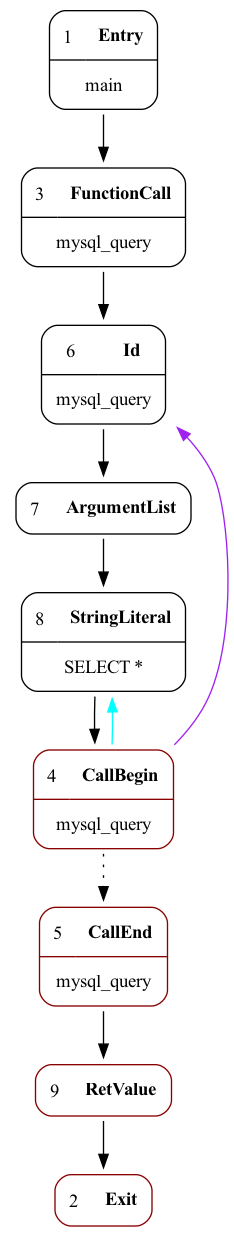

In [10]:
ast = reader.read_ast("../part_1/functioncall/functioncall.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_cfg(cfg)

Visit AST from file code.php
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for IntegerLiteral
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression


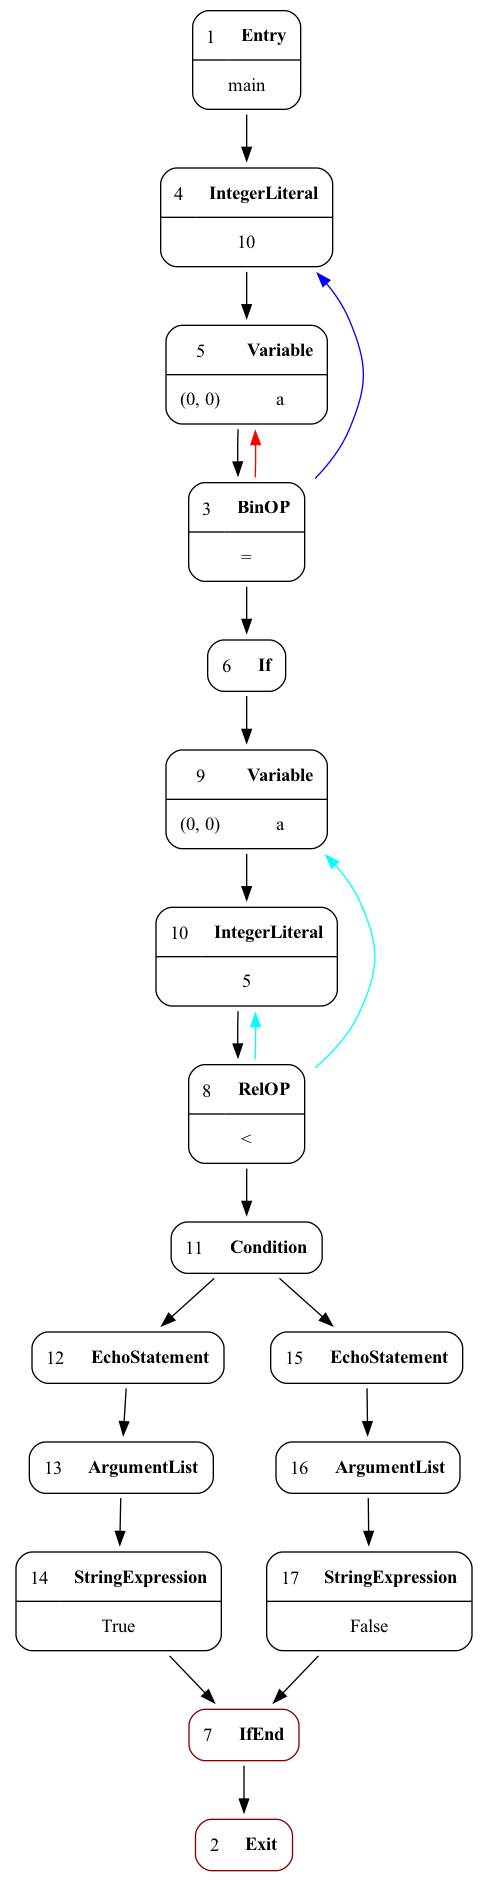

In [11]:
ast = reader.read_ast("../part_1/if/if.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_cfg(cfg)

Visit AST from file code.php
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for IntegerLiteral
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression


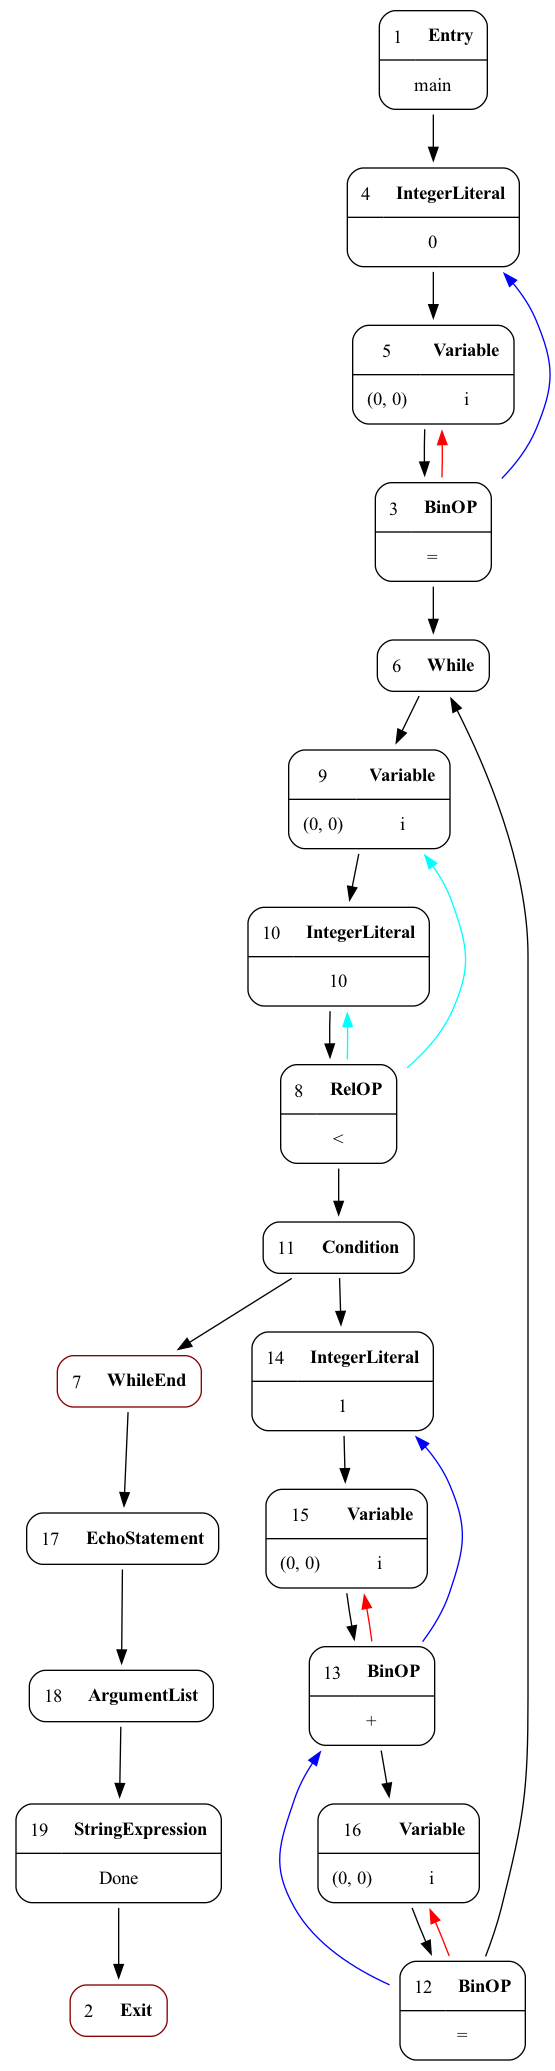

In [12]:
ast = reader.read_ast("../part_1/while/while.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_cfg(cfg)

Visit AST from file code.php
Generic visit for Html
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for IntegerLiteral
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for Variable
Generic visit for IntegerLiteral
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression


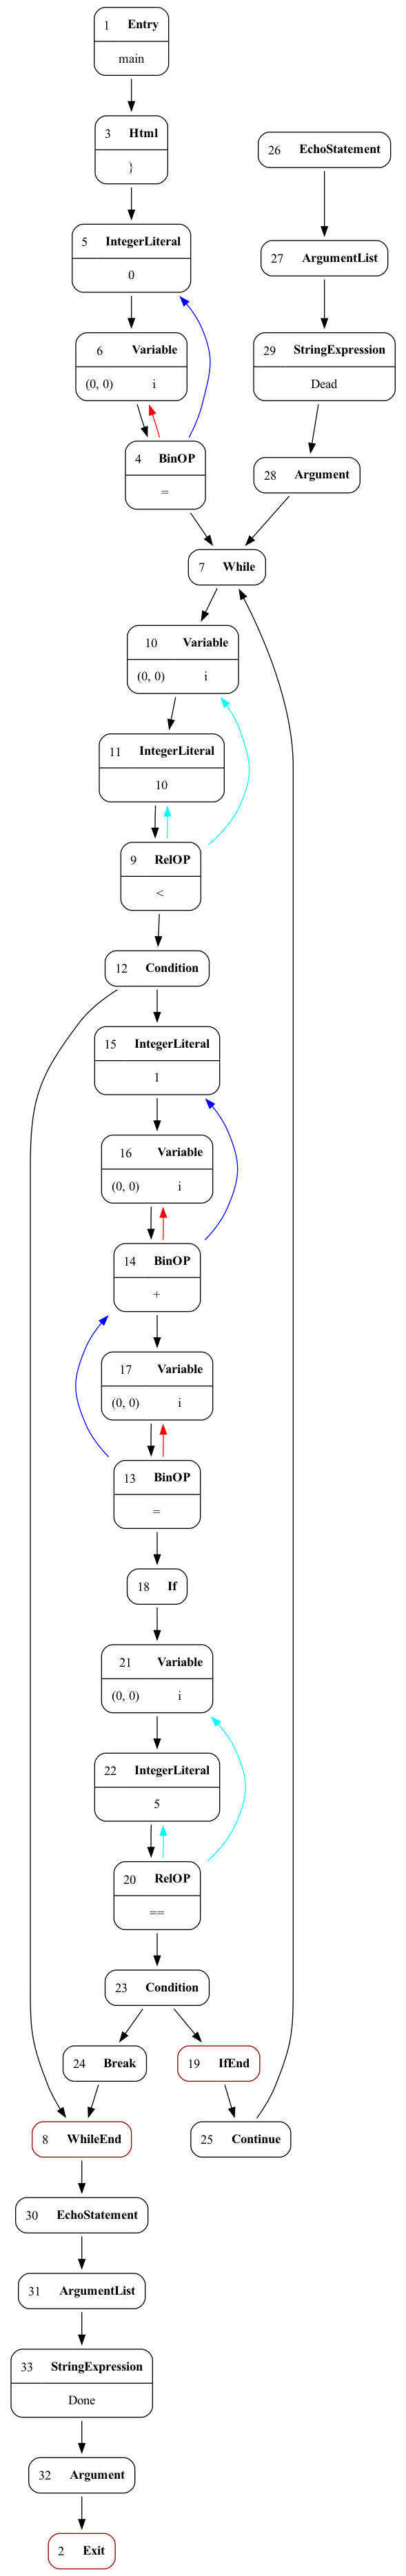

In [13]:
ast = reader.read_ast("../part_1/while/while_continue_break.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_cfg(cfg)